In [6]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from ex2_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Least squares and linear basis functions models
## 1.1 Least squares

== linear regression using normal equation

In [22]:
def mse_to_rmse(loss):
    return np.sqrt(2*loss)

In [43]:
def least_squares(y, tx):
    """calculate the least squares solution with MSE."""
    # ***************************************************
    # returns mse, and optimal weights
    # ***************************************************
    #w_opt = np.dot(np.dot(np.linalg.inv(np.dot(tx.T,tx)),tx.T),y.T) # cf slides 3a
    a = np.dot(tx.T,tx)
    b = np.dot(tx.T,y)
    w_opt = np.linalg.solve(a,b)
    loss = compute_loss(y,tx,w_opt)
    
    return w_opt, loss
    
    

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [44]:
from helpers import *
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    #grid search 
    
    # Generate the grid of parameters to be swept
    grid_w0, grid_w1 = generate_w(num_intervals=100)
    # Start the grid search
    grid_losses = grid_search(y, tx, grid_w0, grid_w1)

    # Select the best combinaison
    loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)

    # Print the results
    print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}".format(
          l=loss_star, w0=w0_star, w1=w1_star, ))

    ## least squares
    w_opt, loss = least_squares(y,tx)
    print(f"Least squares: loss = {loss}, w*={w_opt}")

Test it here

In [45]:
test_your_least_squares()


Grid Search: loss*=15.558703368609525, w0*=72.72727272727272, w1*=13.636363636363626
Least squares: loss = 15.385887868829395, w*=[73.293922   13.47971243]


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [10]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [11]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    # ***************************************************
    # this function should return the matrix formed
    # by applying the polynomial basis to the input data
    # ***************************************************
    matrix = np.ones((len(x),degree+1))
    matrix[:,1] = x
    for i in range(2,degree+1):
        matrix[:,i] = matrix[:,i-1]*matrix[:,1]
    return matrix

build_poly(np.array([1,2,3]),12)

array([[1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00],
       [1.00000e+00, 2.00000e+00, 4.00000e+00, 8.00000e+00, 1.60000e+01,
        3.20000e+01, 6.40000e+01, 1.28000e+02, 2.56000e+02, 5.12000e+02,
        1.02400e+03, 2.04800e+03, 4.09600e+03],
       [1.00000e+00, 3.00000e+00, 9.00000e+00, 2.70000e+01, 8.10000e+01,
        2.43000e+02, 7.29000e+02, 2.18700e+03, 6.56100e+03, 1.96830e+04,
        5.90490e+04, 1.77147e+05, 5.31441e+05]])

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [23]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        # ***************************************************
        # form the data to do polynomial regression.
        # ***************************************************
        tx = build_poly(x,degree)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # least square and calculate RMSE: TODO
        # ***************************************************
        weights, loss = least_squares(y,tx)
        rmse = mse_to_rmse(loss)

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.4718760796342188
Processing 2th experiment, degree=3, rmse=0.25858277667737467
Processing 3th experiment, degree=7, rmse=0.24965870360907416
Processing 4th experiment, degree=12, rmse=0.24511133279075628


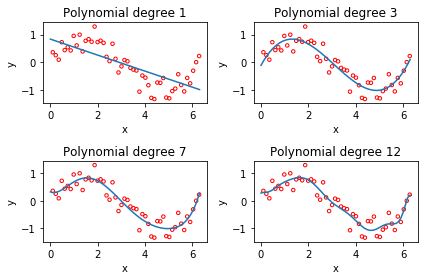

In [46]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [65]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    
    ! convention different from Project 1 implementation!
    """
    # set seed
    np.random.seed(seed)
    shuffled_indices = np.random.permutation(len(x))
    test_set_size = int(len(x)*ratio)
    test_indices = shuffled_indices[test_set_size:]
    train_indices =shuffled_indices[:test_set_size]
    
    return x[train_indices],y[train_indices],x[test_indices],y[test_indices]


Then, test your `split_data` function below.

In [66]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data, and return train and test data: TODO
    # ***************************************************
    x_train, y_train, x_test, y_test =  split_data(x,y,ratio,seed)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form train and test data with polynomial basis function: TODO
    # ***************************************************
    tx_tr = build_poly(x_train,degree)
    tx_te = build_poly(x_test,degree)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate weight through least square: TODO
    # ***************************************************
    w, loss = least_squares(y_train,tx_tr)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively: TODO
    # ***************************************************
    rmse_tr = mse_to_rmse(loss)
    #evaluate
    loss_te = compute_loss(y_test,tx_te,w)
    rmse_te = mse_to_rmse(loss_te)
    
    
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))


In [67]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
proportion=0.9, degree=12, Training RMSE=0.244, Testing RMSE=0.257
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=1.336
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.460
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=2.137
proportion=0.1, degree=12, Training RMSE=0.000, Testing RMSE=3.865


# 3 Ridge Regression
Please fill in the function below.

In [68]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    n,d = tx.shape
    a = np.dot(tx.T,tx)+lambda_*2*n*np.identity(d)
    b = np.dot(tx.T,y)
    w_opt = np.linalg.solve(a,b)
    loss = compute_loss(y,tx,w_opt)
    return w_opt, loss


In [69]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data, and return train and test data: TODO
    # ***************************************************
    x_train, y_train, x_test, y_test =  split_data(x,y,ratio,seed)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form train and test data with polynomial basis function: TODO
    # ***************************************************
    tx_tr = build_poly(x_train,degree)
    tx_te = build_poly(x_test,degree)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ***************************************************
        # ridge regression with a given lambda
        w, loss = ridge_regression(y_train,tx_tr, lambda_)
        rmse_tr.append(mse_to_rmse(loss))
        #evaluate
        loss_te = compute_loss(y_test,tx_te,w)
        rmse_te.append(mse_to_rmse(loss_te))
        # ***************************************************
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)



proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.335
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.334
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.228, Testing RMSE=0.333
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.229, Testing RMSE=0.329
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.230, Testing RMSE=0.319
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.232, Testing RMSE=0.302
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.237, Testing RMSE=0.283
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.246, Testing RMSE=0.276
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.264, Testing RMSE=0.298
proportion=0.5, degree=7, lambda=0.193, 

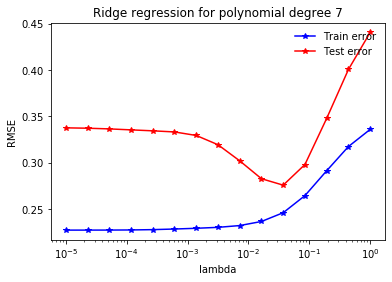

In [70]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)